#  Remote debugging of experiments Transcriptic
Transcriptic spends a lot of time interfacing and sometimes reengineering instrumentation to fully interface with the Transcriptic platform. Whilst sometimes time consuming for engineers this deep integration enables platform users an unprecedented level of access to instrument diagnostic data. The ease with each diagnostic data can be accessed means that experiments can be debugged and rectified extremely quickly. Here is just one example of this.

In [4]:
from transcriptic import api
from transcriptic import Run, Container, Dataset
from transcriptic.analysis import spectrophotometry
from transcriptic.config import Connection
import pandas as pd
import matplotlib as plt
from IPython.display import display, Image, HTML, SVG

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # or 'svg'
plt.style.use('ggplot')

api = Connection.from_file("~/.transcriptic")
api.update_environment(org_id="ellis_lab")

In this experiment I was transferring from some old bacterial cultures to grow up some fresh stocks. Simply the experiment populates a plate with media and transfers 25µL of old culture into the new media and incubates these at 37C for 8 hours. OD600 measurements were taken every 30 minutes. First we fetch the run and look at the datasets.

In [5]:
myRun = Run("r18ekx48p9fsm")

In [6]:
myRun.data

,Name,DataType,Datasets
0,OD600_0,absorbance,<transcriptic.objects.Dataset object at 0x10d7...
1,OD600_1,absorbance,<transcriptic.objects.Dataset object at 0x10d7...
2,OD600_10,absorbance,<transcriptic.objects.Dataset object at 0x1060...
3,OD600_11,absorbance,<transcriptic.objects.Dataset object at 0x10d7...
4,OD600_12,absorbance,<transcriptic.objects.Dataset object at 0x10d7...
5,OD600_13,absorbance,<transcriptic.objects.Dataset object at 0x105e...
6,OD600_14,absorbance,<transcriptic.objects.Dataset object at 0x10d7...
7,OD600_15,absorbance,<transcriptic.objects.Dataset object at 0x10d7...
8,OD600_16,absorbance,<transcriptic.objects.Dataset object at 0x10d7...
9,OD600_2,absorbance,<transcriptic.objects.Dataset object at 0x10d7...


## Let's see how the OD600's look after incubation
I'll just grab the datasets corresponding to the starting and final OD600 measurements

In [31]:
dsstart = myRun.data["Datasets"][0].data
dsfinal = myRun.data["Datasets"][8].data
ds = pd.concat([dsstart, dsfinal])
ds

,A1,A2,B1,B2,C1,C2,D1,D2
0,0.472701,0.045183,0.046357,0.048888,0.046595,0.045925,0.04588,0.055094
0,1.129373,0.045456,0.047075,0.048565,0.049632,0.046863,0.04635,0.063081


### hmmm, looks a little weird, they should all look the same, let's plot it!

[<matplotlib.text.Text at 0x113b20390>, <matplotlib.text.Text at 0x113b68910>]

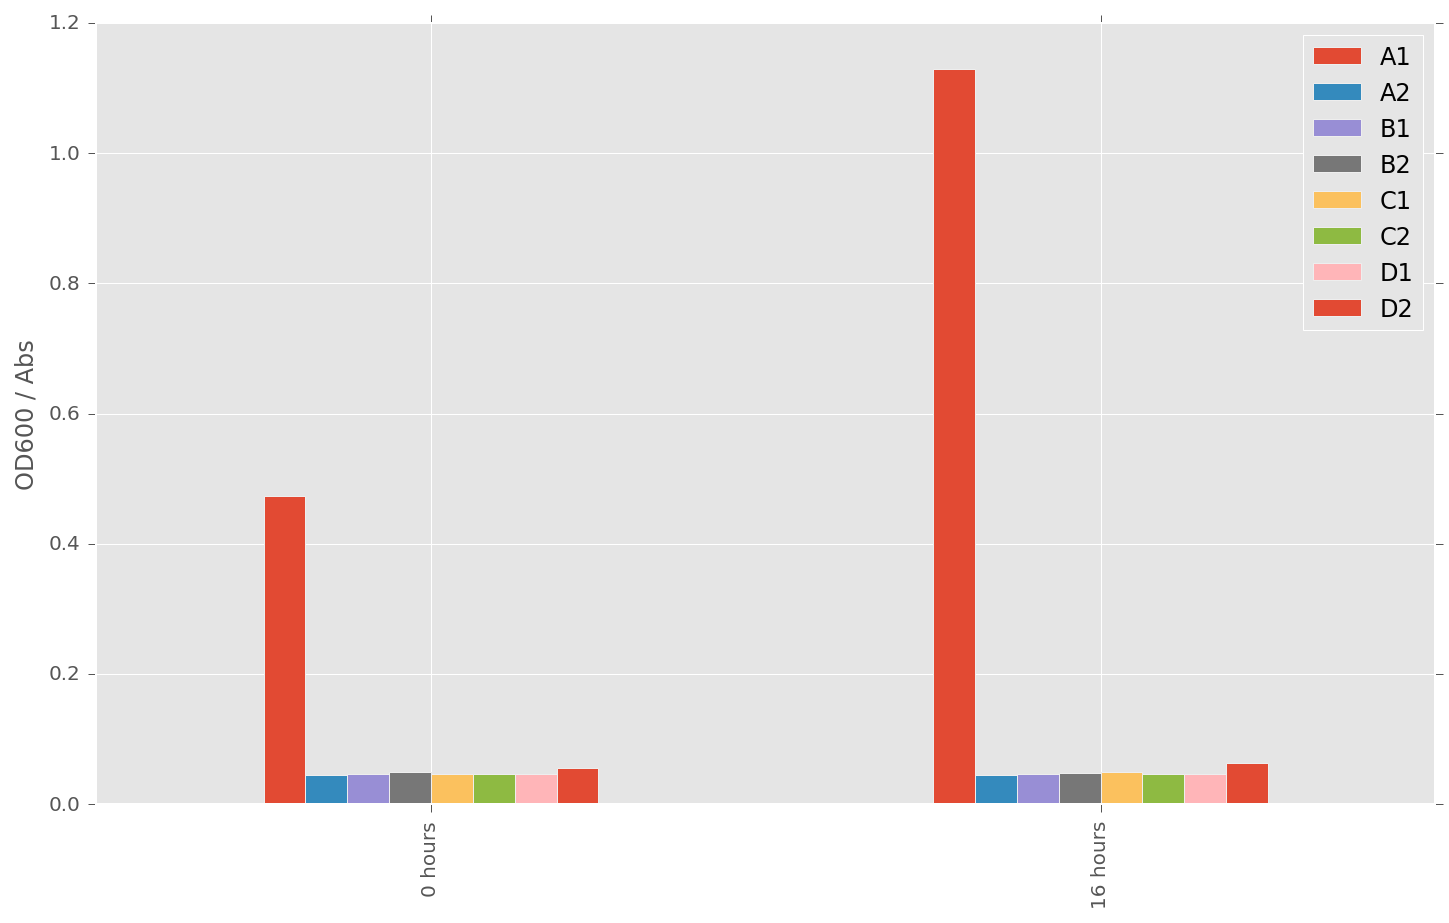

In [45]:
fig = ds.plot(kind="bar",figsize=[12,7]) 
fig.set_ylabel("OD600 / Abs")
fig.set_xticklabels(("0 hours", "16 hours"))

### Woah you can see that well A1 was the only well that showed any growth (increase in OD600 Abs)
We need to find out what happened with the other wells, let's investigate. First of all I'll check the container to see if the volumes were correct.

In [50]:
myRun.containers

,Name,container_id,Type,Status,Storage Condition,Containers
0,abs_plate,ct18cxfbdz68yp,96-flat,available,cold_4,Container(abs_plate)
1,abs_plate_31_11_2015,ct18enc333fhzt,96-flat,available,cold_4,Container(abs_plate_31_11_2015)


I'm interested in `abs_plate_31...`

In [51]:
myPlate = Container('ct18enc333fhzt')
myPlate.aliquots[0:8]

,Id,Name,Volume
0,aq18enmnhhrsuc,None,150.0
1,aq18enmnhj2kmm,None,150.0
2,aq18enmnhjbddv,None,150.0
3,aq18enmnhjpdd7,None,150.0
4,aq18enmnjxdq62,None,150.0
5,aq18enmnjxqm2b,None,150.0
6,aq18enmnjy2gwm,None,150.0
7,aq18enmnjybapv,None,150.0


### hmm all of the wells of interest have 150 µL so that isn't the issue. Let's take a look at the plate innoculation
The innoculation was done by transferring old liquid cultures to blank media with a `pipette` instruction, corresponding to index 7 in the instruction list.

In [11]:
myRun.instructions.head(10)

,Name,Started,Completed,Instructions
0,image_plate,None,2015-12-02T15:38:41.778-08:00,<transcriptic.objects.Instruction object at 0x...
1,cover,None,2015-12-02T15:40:59.681-08:00,<transcriptic.objects.Instruction object at 0x...
2,incubate,None,2015-12-02T17:10:20.723-08:00,<transcriptic.objects.Instruction object at 0x...
3,image_plate,None,2015-12-02T17:26:07.793-08:00,<transcriptic.objects.Instruction object at 0x...
4,dispense,None,2015-12-02T17:27:31.593-08:00,<transcriptic.objects.Instruction object at 0x...
5,dispense,None,2015-12-02T17:27:32.832-08:00,<transcriptic.objects.Instruction object at 0x...
6,uncover,None,2015-12-02T17:27:56.845-08:00,<transcriptic.objects.Instruction object at 0x...
7,pipette,2015-12-02T17:30:35.345-08:00,2015-12-02T17:32:53.402-08:00,<transcriptic.objects.Instruction object at 0x...
8,cover,None,2015-12-02T17:44:28.744-08:00,<transcriptic.objects.Instruction object at 0x...
9,incubate,2015-12-02T17:50:02.255-08:00,2015-12-02T18:51:06.054-08:00,<transcriptic.objects.Instruction object at 0x...


In [14]:
pipetteInstruction = myRun.instructions["Instructions"][7]

# Liquid handler diagnostics
Because Transcriptic deeply integrated the liquid handler into the platform, I'm going to dive into the pressure diagnostic data for the liquid handler during the execution of instruction 7.

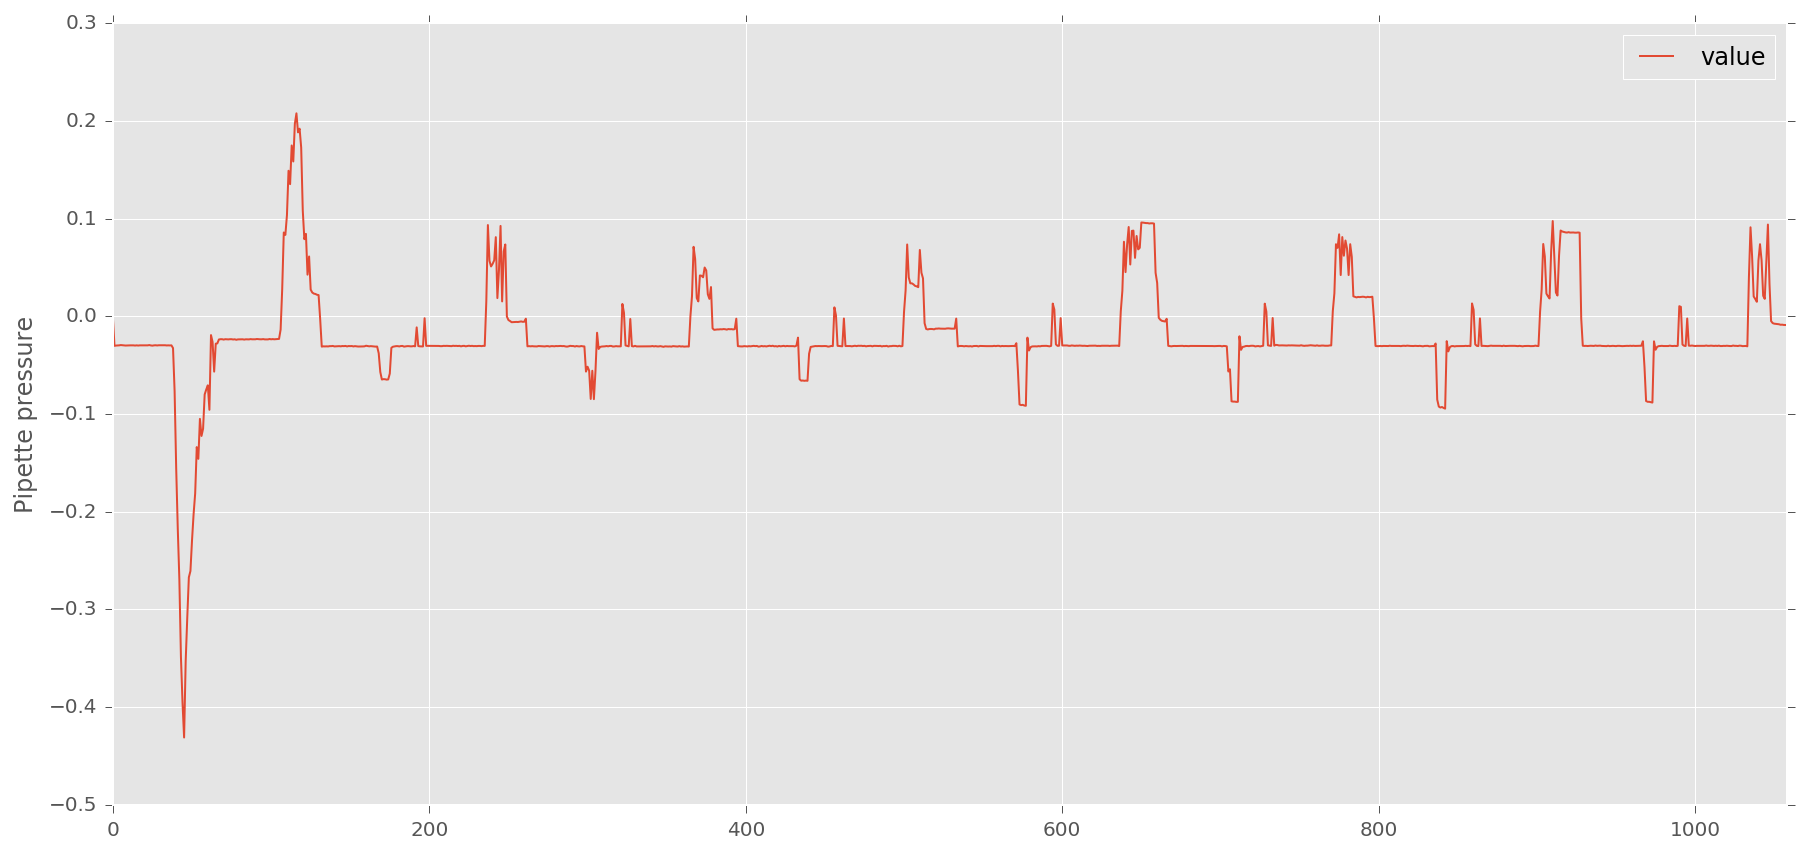

In [52]:
mon = pipetteInstruction.monitoring(data_type="pressure").plot(figsize=[15,7])
mon.set_ylabel("Pipette pressure")

### Found it!
Look at that first pipetting operation for the transfer to A1, the pressure amplitudes are much higher than for the other transfers. The reduced amplitudes after the initial transfer suggest that the pipette tip was clogged following the initial transfer. This makes sense as the bacterial cultures being transferred were not re dispersed prior to pipetting. To avoid this error in the future I can add a mixing step prior to liquid handling to ensure the pellet is properly dispersed before pipetting.

# Debugging
This always blows my mind, I can't picture a time in my scientific career where I've had such ease of access to data about the execution of my experiments. Being able to go back and analyse every step of a protocol is something that most people have never really had access to. My hope is that with more powerful tools and greater access to diagnostics of experiments people can truly begin to create reproducible science.